# Projeto da disciplina de Modelagem Preditiva e Descritiva I - UFPE

Tadao Ando Junior (tjunior@atech.com.br)

## Preparação do ambiente

In [245]:
#Bibliotecas de manipualção e visualização de dados
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
import os.path

# Carga do arquivo no formato arff
from scipy.io.arff import loadarff 

# Préprocessamento de atributos categóricos
from sklearn.preprocessing import OneHotEncoder

# Seleção de test/train sets
from sklearn.model_selection import train_test_split

# Cross-validation
from sklearn.model_selection import KFold, StratifiedKFold

# Busca exaustiva por parametros em ranges especificados
from sklearn.model_selection import GridSearchCV

# Modelos
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Métricas
from sklearn.metrics import plot_confusion_matrix, classification_report, plot_roc_curve, accuracy_score

from yellowbrick.classifier import ROCAUC
from yellowbrick.datasets import load_game

import warnings
warnings.filterwarnings('ignore')

In [250]:
# Define tamanho padrão dos plotes
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 20]

## Carga do banco de dados

In [225]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# Verifica se estamos rodando dentro do GoogleCollab
if IN_COLAB:
        print('Loading dataset from github tadj8/mpd')
        dataset_name = 'collins.arff'

        # Se o arquivo já foi baixado não é necessário baixar novamente
        if not os.path.isfile(dataset_name):
                urllib.request.urlretrieve("https://raw.githubusercontent.com/tadj8/mpd/main/datasets/collins.arff", dataset_name)
        raw_data = loadarff("collins.arff")
else:
        print('Reading dataset from local file')
        raw_data = loadarff("datasets/collins.arff")

# Converte dados brutos para um dataframe pandas
df_orig = pd.DataFrame(raw_data[0])

Reading dataset from local file


In [175]:
df_orig

,Text,FirstPerson,InnerThinking,ThinkPositive,ThinkNegative,ThinkAhead,ThinkBack,Reasoning,Share_SocTies,Direct_Activity,...,SpaceInterval,Motion,PastEvents,TimeInterval,ShiftingEvents,Text_Coverage,Genre,Counter,Corpus,Corp.Genre
0,b'A01.TXT',0.09,1.72,0.62,0.70,2.15,0.66,1.23,2.24,0.48,...,0.75,0.35,2.55,1.63,0.79,28.31,b'1',1.0,b'1',b'101'
1,b'A02.TXT',0.13,1.48,0.38,0.63,1.85,0.93,1.48,2.28,0.21,...,0.59,0.25,1.77,1.39,0.80,23.91,b'1',2.0,b'1',b'101'
2,b'A03.TXT',0.04,1.72,0.34,1.12,1.55,0.90,1.68,2.84,0.17,...,0.65,0.17,2.32,1.94,0.82,30.15,b'1',3.0,b'1',b'101'
3,b'A04.TXT',0.00,2.74,0.90,2.43,1.21,1.03,3.46,3.06,0.22,...,0.67,0.09,1.89,1.71,0.81,29.43,b'1',4.0,b'1',b'101'
4,b'A05.TXT',0.26,2.15,0.39,0.61,2.28,0.75,1.93,1.84,0.44,...,0.75,0.35,1.54,1.80,0.96,27.89,b'1',5.0,b'1',b'101'
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,b'rFR5.txt',0.49,3.25,0.41,2.10,1.07,0.25,3.29,1.93,1.65,...,0.70,0.90,1.19,1.77,1.07,34.11,b'15',996.0,b'2',b'215'
996,b'rFR6.txt',5.17,4.86,1.08,0.99,1.26,0.45,3.51,1.17,0.00,...,1.26,0.18,1.35,1.08,1.26,38.95,b'15',997.0,b'2',b'215'
997,b'rFR7.txt',0.00,2.70,1.30,1.21,1.21,1.30,2.16,1.35,0.18,...,1.08,0.31,5.13,1.71,1.08,40.36,b'15',998.0,b'2',b'215'
998,b'rFR8.txt',0.73,1.96,0.41,0.37,1.06,0.65,2.04,0.86,0.08,...,3.02,1.02,4.41,0.61,0.41,42.53,b'15',999.0,b'2',b'215'


### Preparação e análise do dataset

In [176]:
df = df_orig.copy()

# Nosso target:
#    Corp.Genre : Combinação do Gênero (atribuído pelos compiladores do corpora) e corpus (1=Brown e 2=Frown)

# Gênero é categórica e não tem ordinalidade entre as classes. Portanto, decidimos usar OneHotEncoding para transformar
# em numérica:
# df = df.join(pd.get_dummies(df['Genre'], prefix='genre'))
df['Corp.Genre'] = df['Corp.Genre'].factorize()[0]

# Remove colunas que não utilizaremos:
#   Genre / Corpus : As duas colunas juntas são o target e já estão combinadas em Corp.Genre, portanto podem ser removidas
#   Text : nome do texto de origem
#
df.drop(['Text', 'Corpus', 'Counter', 'Genre'], axis=1, inplace=True)
df_orig.drop(['Text', 'Corpus', 'Counter', 'Genre'], axis=1, inplace=True)

In [179]:
df_orig

,FirstPerson,InnerThinking,ThinkPositive,ThinkNegative,ThinkAhead,ThinkBack,Reasoning,Share_SocTies,Direct_Activity,Interacting,Notifying,LinearGuidance,WordPicture,SpaceInterval,Motion,PastEvents,TimeInterval,ShiftingEvents,Text_Coverage,Corp.Genre
0,0.09,1.72,0.62,0.70,2.15,0.66,1.23,2.24,0.48,0.00,2.11,5.23,5.01,0.75,0.35,2.55,1.63,0.79,28.31,b'101'
1,0.13,1.48,0.38,0.63,1.85,0.93,1.48,2.28,0.21,0.17,1.77,3.46,4.34,0.59,0.25,1.77,1.39,0.80,23.91,b'101'
2,0.04,1.72,0.34,1.12,1.55,0.90,1.68,2.84,0.17,0.17,2.84,5.03,5.85,0.65,0.17,2.32,1.94,0.82,30.15,b'101'
3,0.00,2.74,0.90,2.43,1.21,1.03,3.46,3.06,0.22,0.31,2.47,3.15,3.28,0.67,0.09,1.89,1.71,0.81,29.43,b'101'
4,0.26,2.15,0.39,0.61,2.28,0.75,1.93,1.84,0.44,0.35,2.54,5.79,3.16,0.75,0.35,1.54,1.80,0.96,27.89,b'101'
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.49,3.25,0.41,2.10,1.07,0.25,3.29,1.93,1.65,2.39,3.17,4.28,4.20,0.70,0.90,1.19,1.77,1.07,34.11,b'215'
996,5.17,4.86,1.08,0.99,1.26,0.45,3.51,1.17,0.00,0.58,2.92,4.72,7.11,1.26,0.18,1.35,1.08,1.26,38.95,b'215'
997,0.00,2.70,1.30,1.21,1.21,1.30,2.16,1.35,0.18,0.04,2.25,10.61,6.74,1.08,0.31,5.13,1.71,1.08,40.36,b'215'
998,0.73,1.96,0.41,0.37,1.06,0.65,2.04,0.86,0.08,1.18,1.47,11.23,11.02,3.02,1.02,4.41,0.61,0.41,42.53,b'215'


In [177]:
# Cria um dicionario com o mapeamento entre os valores originais e os fatorizados e vice-versa para consulta posterior
orig_to_ordinal={}
ordinal_to_orig={}
keys=list(df_orig['Corp.Genre'].unique())

for i in range(0,30):
        orig_to_ordinal[keys[i]] = i
        ordinal_to_orig[i]=keys[i]

In [178]:
# Identificando valores ordenados pela frequencia
df['Corp.Genre'].value_counts().sort_values()

26     6
11     6
29     9
14     9
17    17
18    17
3     17
2     17
10    24
25    24
16    27
1     27
13    29
24    29
9     29
27    29
12    29
28    29
7     30
22    30
4     36
19    36
15    44
0     44
5     48
20    48
6     75
21    75
23    80
8     80
Name: Corp.Genre, dtype: int64

In [87]:
# Gera profile do dataset com pandas_profiling (não consegui rodar isso no google collab, somente localmente)
# O relatório pode ser visto com um browser

# from pandas_profiling import ProfileReport
# profile = ProfileReport(df)
# profile.to_file('report_corpus.html')

Export report to file: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


## Experimentos

In [237]:
# Função de análise usando kfold + gridsearch
def grid_search(skf, model, parameters, X, y):
      accuracies_list = []
      fold = 0

      for train, test in skf.split(X, y):
            X_train, X_test = X.iloc[train], X.iloc[test]
            y_train, y_test = y.iloc[train], y.iloc[test]
    
            grid = GridSearchCV(estimator = model,
                    param_grid = parameters,
                    scoring = 'accuracy',
                    cv = 5)
        
            grid.fit(X_train, y_train)

            y_pred = grid.predict(X_test)
    
            print("Melhor parametro:", grid.best_params_)         
            print("Fold %d: %.3f" %(fold, accuracy_score(y_test, y_pred)))
            
            accuracies_list.append(accuracy_score(y_test, y_pred))
            fold += 1

      accuracies = np.array(accuracies_list)
      print("")
      print("Acurácia média (desvio) : %.3f +- (%.3f)" %(accuracies.mean(), accuracies.std()))
      print("Melhores hiperparâmetros: %s" % (grid.best_params_))
      return pd.DataFrame(grid.cv_results_)


### kNN

In [248]:
X = df.iloc[:,0:18]
y = df.iloc[:,19]

#Separando o conjunto de dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y)

              precision    recall  f1-score   support

           0       0.32      0.70      0.44        10
           1       0.13      0.43      0.20         7
           2       0.07      0.25      0.11         4
           3       0.00      0.00      0.00         5
           4       0.33      0.23      0.27        13
           5       0.09      0.12      0.11         8
           6       0.05      0.07      0.06        14
           7       0.00      0.00      0.00         4
           8       0.25      0.21      0.23        24
           9       0.15      0.33      0.21         6
          10       0.33      0.25      0.29         8
          11       0.00      0.00      0.00         1
          12       0.07      0.20      0.11         5
          13       0.25      0.50      0.33         4
          14       0.00      0.00      0.00         3
          15       0.45      0.42      0.43        12
          16       0.75      0.38      0.50         8
          17       0.00    

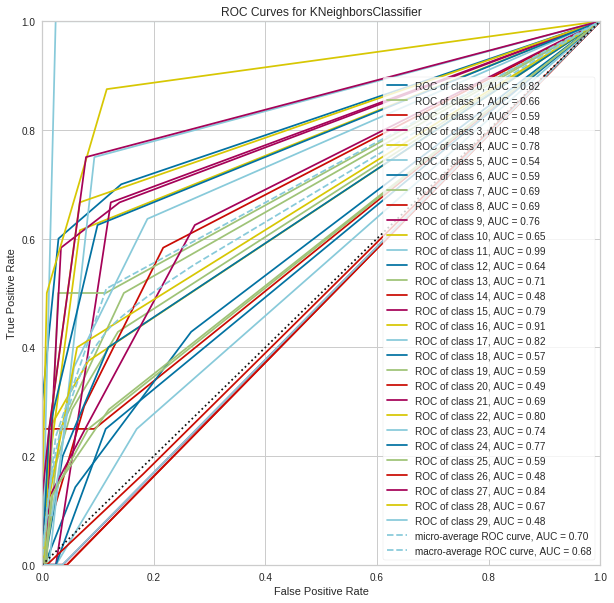

In [251]:
model = KNeighborsClassifier()

# Treinando o modelo
model.fit(X_train, y_train)

# Predição
y_pred = model.predict(X_test)

# Resultados do classificador
print(classification_report(y_test, y_pred))

# plot_confusion_matrix(model, X_test, y_test)

visualizer = ROCAUC(model)
visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show() 

# plot_roc_curve(model, X_test, y_test)

In [236]:
# cross validation + gridsearch
parameters = { 'n_neighbors' : [10, 30, 50, 70] }
grid_search(StratifiedKFold(n_splits=10, random_state=42, shuffle=True), KNeighborsClassifier(), parameters, X_train, y_train)

Melhor parametro: {'n_neighbors': 30}
Fold 0: 0.213
Melhor parametro: {'n_neighbors': 30}
Fold 1: 0.253
Melhor parametro: {'n_neighbors': 10}
Fold 2: 0.267
Melhor parametro: {'n_neighbors': 30}
Fold 3: 0.293
Melhor parametro: {'n_neighbors': 10}
Fold 4: 0.240
Melhor parametro: {'n_neighbors': 10}
Fold 5: 0.160
Melhor parametro: {'n_neighbors': 50}
Fold 6: 0.120
Melhor parametro: {'n_neighbors': 70}
Fold 7: 0.213
Melhor parametro: {'n_neighbors': 30}
Fold 8: 0.267
Melhor parametro: {'n_neighbors': 50}
Fold 9: 0.173

Acurácia média (desvio) : 0.220 +- (0.052)
Melhores hiperparâmetros: {'n_neighbors': 50}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001398,0.000334,0.006228,0.007921,10,{'n_neighbors': 10},0.308824,0.191176,0.205882,0.235294,0.161765,0.194030,0.283582,0.179104,0.253731,0.208955,0.222234,0.044883,3
1,0.001341,0.000193,0.005665,0.004611,30,{'n_neighbors': 30},0.367647,0.147059,0.161765,0.250000,0.220588,0.164179,0.343284,0.194030,0.164179,0.164179,0.217691,0.075219,4
2,0.001506,0.000187,0.035298,0.057183,50,{'n_neighbors': 50},0.279412,0.191176,0.176471,0.235294,0.235294,0.194030,0.283582,0.238806,0.223881,0.223881,0.228183,0.033398,1
3,0.001758,0.000652,0.005457,0.002376,70,{'n_neighbors': 70},0.279412,0.191176,0.235294,0.220588,0.205882,0.134328,0.328358,0.208955,0.208955,0.223881,0.223683,0.048988,2
